# Assignment 5 - Neural Networks Implementation (due: Wed April 15th)

This notebook show neural networks implemnetation on the MNIST hand-written dataset.  Adapted from a version published by https://github.com/jdwittenauer

We are going go over the neural network architecture discussed in class. This includes the feed-forward neural network - from input through the hidden layers to the out put and adjusting the weights as to minimize the loss step-by-step through each layer called **backpropagation.**  We'll implement both unregularized and regularized versions of the neural network cost function and gradient computation in the backpropagation function.  We'll also implement random weight initialization and a method to use the network to make predictions.

Instead of manually going through gradient descent iterations, we'll simply use a package available for minimizing the backpropogation function.

The MNIST data set is available in different sizes and formats from different sources.  We will use the one made avialble here: "ex3data1.mat"

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [4]:
from google.colab import files
files.upload()

Saving y_df.pkl to y_df.pkl
Saving X_df.pkl to X_df.pkl
Saving ex3data1.mat to ex3data1.mat


The data we are loading is a dictionary that contains both input data and output.  The input data is a 2D numpy array X contains 5000 grayscale images of handwritten digits of 0, 1, 2, 3, ... 9.  Each raw of 400 entries between 0 and 255 that are grayscale intensity values of 20X20 pixel representation of a handwritten digit that is unrolled into a single vector.

The output y contains the corresponding labels of 0,1,2, ..., 9.  

Note that in the original convention followed for this dataset: 0 is mapped to 10, while all other labels are exactly the digit they represent.  Unlike in many other programming languages Python entries start at 0 and so we will change 10 back to 0 as it ought to be.

**Multiclass classification:** You may notice that in our logistic regression models the output could only be one of two values: 0 or 1.  However what we are attempting here is an example of multiclass classification: outputs of more than two values - 10 in this case.  Neural networks facilitates this easily. In fact what we will allow now is the terminal layer to consist of multiple activations: 10 in this problem.  We use a function called softmax to make the outputs to be probabilties that adds upto 1.  The predicted value will correspond to the activation node with highest probabilty

### Exercise #1: 

Load the data following the following five cells or by running the 6th cell

- you should have the X and y from data in the dataframes X_df and y_df

In [5]:
##This is a dictionary that contains both input data and output.
data = loadmat('ex3data1.mat')
data

{'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [6]:
data['X'].shape

(5000, 400)

This is the data we will be using through out, let's create some useful variables up-front.

In [0]:
X = data['X']
y = data['y']

In [0]:
#Let us set the values '10' back what it ought to be: 0
y[y==10]=0

#### Let us convert these data sets into dataframes so we can pickle them and move them around without losing integrity

In [0]:
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [0]:
import pickle
X_df = pd.read_pickle('X_df.pkl')
y_df = pd.read_pickle('y_df.pkl')

### Exercise #2:

Display **20** randomly selected images from X_df and display them in two rows by appropriately changing the following code

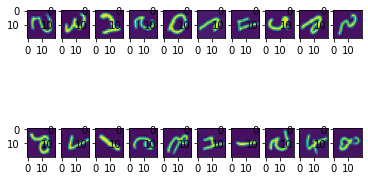

In [11]:
#Let us quickly checkout what is in these data sets:
sample = np.random.randint(0,len(X), 20)
X_samples = [X[i,:] for i in sample]

#plot the digits
i = 0

fig, ax = plt.subplots(nrows=2, ncols=10)
for row in ax:
    for col in row:
        col.imshow(X_samples[i].reshape(20,20))
        i += 1
plt.show()

In [12]:
#Checkout their labels
y[sample].flatten()

array([5, 3, 4, 5, 0, 6, 7, 2, 6, 5, 6, 7, 1, 6, 8, 4, 1, 5, 7, 8],
      dtype=uint8)

**One hot encoding:** Now we need to turn the label array into what is called one-hot-encoded matrix.  The one-hot-matrix is a representation of representation of a n-dimensional vector of values 0, 1, 2, ..., 9 as in here into 10Xn matrix where each column will have all zeros except exactly one 1 in the position corresponding to the value the column represents.  For example 7 will be a column where all entries except the 7th are all zeros and the 7th is a one.

One-hot-encoding is a way to represent a vector with binary entries alone.

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [14]:
#Here is an example of an y entry and its one-hot-encoding
y[0], y_onehot[0,:]

(array([0], dtype=uint8), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

The neural network we're going to build for this exercise has an input layer matching the size of our instance data (400 + the bias unit), a hidden layer with 25 units (26 with the bias unit), and an output layer with 10 units corresponding to our one-hot encoding for the class labels. 

The first piece we need to implement is a cost function to evaluate the loss for a given set of network parameters.  The source mathematical function is in the exercise text (and looks pretty intimidating).  Here are the functions required to compute the cost.

In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Forward propogation and Cost

In [0]:
#Forward propogation: This takes us through one sweep from input through one hidden layer to the outputs
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    #First insert a a row of ones into the X data - 0th column
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    
    #Caluculate the X*Theta
    z2 = a1 * theta1.T
    
    #now apply the sigmoid function and then insert a column of ones
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    
    #Calculate X*Theta
    z3 = a2 * theta2.T
    
    #The outputs
    h = sigmoid(z3)
    
    #Now return all the calculates values that we need for calculating and then backpropagation
    return a1, z2, a2, z3, h

In [0]:
## Cost
def cost(params, input_size, hidden_size1, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    n1 = hidden_size1 * (input_size + 1)
    n2 = n1 + num_labels * (hidden_size1 + 1)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:n1], (hidden_size1, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[n1:n2], (num_labels, (hidden_size1 + 1))))

    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = - np.multiply(y[i,:], np.log(h[i,:]))
        second_term = - (np.multiply((1 - y[i,:]), np.log(1 - h[i,:])))
        J += np.sum(first_term + second_term)
    
    J = J / m
    
    return J

We've used the sigmoid function before so that's not new.  The forward-propagate function computes the hypothesis for each training instance given the current parameters.  It's output shape should match the same of our one-hot encoding for y.  We can test this real quick to convince ourselves that it's working as expected (the intermediate steps are also returned as these will be useful later).

### Exercise #3

Work the rest of this application (except for exercise 4 later) using hidden_size2 set to 50

In [18]:
# initial setup
input_size = 400
hidden_size1 = 50
num_labels = 10
learning_rate = 1

# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_size1 * (input_size + 1) + num_labels * (hidden_size1 + 1)) - 0.5) * 0.25

m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

# unravel the parameter array into parameter matrices for each layer
theta1 = np.matrix(np.reshape(params[:hidden_size1 * (input_size + 1)], (hidden_size1, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size1 * (input_size + 1):], (num_labels, (hidden_size1 + 1))))

theta1.shape, theta2.shape

((50, 401), (10, 51))

In [19]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 50), (5000, 51), (5000, 10), (5000, 10))

The cost function, after computing the hypothesis matrix h, applies the cost equation to compute the total error between y and h.

In [20]:
cost(params, input_size, hidden_size1, num_labels, X, y_onehot, learning_rate)

7.176108966190751

## Forward propogation with regularization and Cost

Our next step is to add regularization to the cost function.  If you're following along in the exercise text and thought the last equation looked ugly, this one looks REALLY ugly.  It's actually not as complicated as it looks though - in fact, the regularization term is simply an addition to the cost we already computed.  Here's the revised cost function.

In [0]:
def cost(params, input_size, hidden_size1, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    
    n1 = hidden_size1 * (input_size + 1)
    n2 = n1 + num_labels * (hidden_size1 + 1)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:n1], (hidden_size1, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[n1:n2], (num_labels, (hidden_size1 + 1))))

    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    return J

In [22]:
cost(params, input_size, hidden_size1, num_labels, X, y_onehot, learning_rate)

7.186795909823177

Next up is the backpropagation algorithm.  Backpropagation computes the parameter updates that will reduce the error of the network on the training data.  The first thing we need is a function that computes the gradient of the sigmoid function we created earlier.

In [0]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

## Backpropogation

Now we're ready to implement backpropagation to compute the gradients.  Since the computations required for backpropagation are a superset of those required in the cost function, we're actually going to extend the cost function to also perform backpropagation and return both the cost and the gradients.

In [0]:
def backprop(params, input_size, hidden_size1, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size1 * (input_size + 1)], (hidden_size1, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size1 * (input_size + 1):], (num_labels, (hidden_size1 + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        #insert a one in first position for bias
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

The hardest part of the backprop computation (other than understanding WHY we're doing all these calculations) is getting the matrix dimensions right.  By the way, if you find it confusing when to use A * B vs. np.multiply(A, B), you're not alone.  Basically the former is a matrix multiplication and the latter is an element-wise multiplication (unless A or B is a scalar value, in which case it doesn't matter).  I wish there was a more concise syntax for this (maybe there is and I'm just not aware of it).

Anyway, let's test it out to make sure the function returns what we're expecting it to.

In [25]:
J, grad = backprop(params, input_size, hidden_size1, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(7.186795909823177, (20560,))

### Exercise 4:

1.  Split the datasets X_df and y_onehot into 80% for training and the rest for testing using:
from sklearn.model_selection import train_test_split

2. Then use only the train datasets to train (in the next cell)

In [28]:
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X,y_onehot,test_size=0.20,random_state=23)

# minimize the objective function
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size1, num_labels, X_train, y_train, learning_rate), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

     fun: 0.6447026965253835
     jac: array([-3.52686805e-04,  0.00000000e+00,  0.00000000e+00, ...,
       -2.65683093e-05, -6.06850510e-05, -2.26970570e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 14
  status: 3
 success: False
       x: array([-0.16000625, -0.1035491 , -0.03465699, ...,  0.35022924,
       -1.71524015,  1.93676715])

### Exercise 5:

1.  Now use only the test datasets to predict (in the next cell
2.  And calclate the accuray by comparing to the test labels

In [36]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size1 * (input_size + 1)], (hidden_size1, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size1 * (input_size + 1):], (num_labels, (hidden_size1 + 1))))

a1, z2, a2, z3, h = forward_propagate(X_test, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1))
y_pred

array([[3],
       [1],
       [6],
       [4],
       [0],
       [3],
       [8],
       [6],
       [9],
       [4],
       [5],
       [8],
       [8],
       [9],
       [9],
       [0],
       [0],
       [5],
       [8],
       [7],
       [7],
       [4],
       [9],
       [3],
       [7],
       [0],
       [7],
       [1],
       [0],
       [2],
       [4],
       [9],
       [8],
       [6],
       [4],
       [0],
       [0],
       [7],
       [4],
       [4],
       [4],
       [1],
       [8],
       [9],
       [5],
       [4],
       [8],
       [1],
       [1],
       [1],
       [0],
       [7],
       [7],
       [6],
       [7],
       [9],
       [2],
       [7],
       [1],
       [5],
       [7],
       [8],
       [7],
       [0],
       [7],
       [1],
       [5],
       [2],
       [2],
       [2],
       [3],
       [8],
       [8],
       [5],
       [8],
       [1],
       [6],
       [8],
       [2],
       [5],
       [8],
       [2],
       [1],
    

In [0]:
y_test = np.array(np.argmax(y_test, axis=1))

Finally we can compute the accuracy to see how well our trained network is doing.

In [39]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_test)]
accuracy = sum(correct)/len(correct)
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 93.30000000000001%


### Optional exercise: complete the same train and test parts for the regualrized version of the model below

### Regularization:

We still have one more modification to make to the backprop function - adding regularization to the gradient calculations.  The final regularized version is below.

In [0]:
def backprop(params, input_size, hidden_size1, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size1 * (input_size + 1)], (hidden_size1, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size1 * (input_size + 1):], (num_labels, (hidden_size1 + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

In [41]:
J, grad = backprop(params, input_size, hidden_size1, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(7.186795909823177, (20560,))

We're finally ready to train our network and use it to make predictions.  This is roughly similar to the previous exercise with multi-class logistic regression.

In [42]:
from scipy.optimize import minimize

# Split data
X_train, X_test, y_train, y_test = train_test_split(X,y_onehot,test_size=0.20,random_state=23)

# minimize the objective function
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size1, num_labels, X_train, y_train, learning_rate), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


     fun: 0.3941434055801533
     jac: array([-6.20456306e-05, -1.33990845e-05, -4.89247339e-06, ...,
       -1.48921193e-04, -2.50130878e-05, -8.87865063e-04])
 message: 'Linear search failed'
    nfev: 214
     nit: 13
  status: 4
 success: False
       x: array([-0.36468762, -0.05359634, -0.01956989, ...,  0.03565038,
       -1.84800928,  2.59223785])

We put a bound on the number of iterations since the objective function is not likely to completely converge.  Our total cost has dropped below 0.5 though so that's a good indicator that the algorithm is working.  Let's use the parameters it found and forward-propagate them through the network to get some predictions.

In [0]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size1 * (input_size + 1)], (hidden_size1, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size1 * (input_size + 1):], (num_labels, (hidden_size1 + 1))))

a1, z2, a2, z3, h = forward_propagate(X_test, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1))
y_pred
y_test = np.array(np.argmax(y_test, axis=1))

Finally we can compute the accuracy to see how well our trained network is doing.

In [44]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y_test)]
accuracy = sum(correct)/len(correct)
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 95.19999999999999%


And we're done!  We've successfully implemented a rudimentary feed-forward neural network with backpropagation and used it to classify images of handwritten digits.  In the next exercise we'll look at another power supervised learning algorithm, support vector machines.